In [0]:
# import os
# os.environ['KERAS_BACKEND'] = 'theano'
# import keras.backend
# keras.backend.image_data_format()
# keras.backend.set_image_data_format('theano')

from keras import backend as K
# K.common.set_image_dim_ordering('th')

In [105]:
# import os
# os.environ['KERAS_BACKEND'] = 'theano'
import pickle
import numpy as np
import logging
from tqdm import tqdm
from google.colab import drive
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
FN = 'predict'

In [0]:
import os
#os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

In [108]:
import keras
keras.__version__

'2.3.1'

In [0]:
FN0 = 'vocabulary-embedding'

In [0]:
FN1 = 'train'

In [0]:
maxlend=50 # 0 - if we dont want to use description at all
maxlenh=25
maxlen = maxlend + maxlenh
rnn_size = 512
rnn_layers = 3  # match FN1
batch_norm=False

In [0]:
activation_rnn_size = 40 if maxlend else 0

Training Parameters

In [0]:
seed=42
p_W, p_U, p_dense, p_emb, weight_decay = 0, 0, 0, 0, 0
optimizer = 'adam'
batch_size=64

In [0]:
nb_train_samples = 7000
nb_val_samples = 700

# Read Word Embeddings

In [0]:
with open('/content/drive/My Drive/dataset/headline_generator/10000_outputs/%s.pkl'%FN0, 'rb') as fp:
    embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

In [0]:
nb_unknown_words = 10

In [117]:
print('dimension of embedding space for words',embedding_size)
print('vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words)
print('total number of different words',len(idx2word), len(word2idx))
print('number of words outside vocabulary which we can substitue using glove similarity', len(glove_idx2idx))
print('number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(glove_idx2idx))

dimension of embedding space for words 300
vocabulary size 10000 the last 10 words can be used as place holders for unknown/oov words
total number of different words 2509378 2509378
number of words outside vocabulary which we can substitue using glove similarity 22972
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov) 2476406


In [0]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

In [0]:
for i in range(vocab_size-nb_unknown_words, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'

In [0]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [0]:
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys

In [0]:
def prt(label, x):
    print(label+':',)
    for w in x:
        print(idx2word[w],)
    print()

# Model

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.layers.core import Lambda
import keras.backend as K

In [0]:
random.seed(seed)
np.random.seed(seed)

In [0]:
regularizer = l2(weight_decay) if weight_decay else None

## rnn model

In [127]:
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, embedding_size,
                        input_length=maxlen,
                        W_regularizer=regularizer, dropout=p_emb, weights=[embedding], mask_zero=True,
                        name='embedding_1'))
for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                W_regularizer=regularizer, U_regularizer=regularizer,
                b_regularizer=regularizer, dropout_W=p_W, dropout_U=p_U,
                name='lstm_%d'%(i+1)
                  )
    rnn_model.add(lstm)
    rnn_model.add(Dropout(p_dense, name='dropout_%d'%(i+1)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(10000, 300, input_length=75, weights=[array([[-..., mask_zero=True, name="embedding_1", embeddings_regularizer=None)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=True, name="lstm_1", kernel_regularizer=None, bias_regularizer=None, recurrent_regularizer=None, dropout=0, recurrent_dropout=0)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequence

## load

In [0]:
import h5py
def str_shape(x):
    return 'x'.join(map(str,x.shape))

def inspect_model(model):
    print(model.name)
    for i,l in enumerate(model.layers):
        print(i, 'cls=%s name=%s'%(type(l).__name__, l.name))
        weights = l.get_weights()
        for weight in weights:
            print(str_shape(weight),)
        print()

def load_weights(model, filepath):
    """Modified version of keras load_weights that loads as much as it can
    if there is a mismatch between file and model. It returns the weights
    of the first layer in which the mismatch has happened
    """
    print('Loading', filepath, 'to', model.name)
    flattened_layers = model.layers
    with h5py.File(filepath, mode='r') as f:
        # new file format
        layer_names = [n.decode('utf8') for n in f.attrs['layer_names']]

        # we batch weight value assignments in a single backend call
        # which provides a speedup in TensorFlow.
        weight_value_tuples = []
        for name in layer_names:
            print(name)
            g = f[name]
            weight_names = [n.decode('utf8') for n in g.attrs['weight_names']]
            if len(weight_names):
                weight_values = [g[weight_name] for weight_name in weight_names]
                try:
                    layer = model.get_layer(name=name)
                except:
                    layer = None
                if not layer:
                    print('failed to find layer', name, 'in model')
                    print('weights', ' '.join(str_shape(w) for w in weight_values))
                    print('stopping to load all other layers')
                    weight_values = [np.array(w) for w in weight_values]
                    break
                symbolic_weights = layer.trainable_weights + layer.non_trainable_weights
                weight_value_tuples += zip(symbolic_weights, weight_values)
                weight_values = None
        K.batch_set_value(weight_value_tuples)
    return weight_values

In [129]:
weights = load_weights(rnn_model, '/content/drive/My Drive/dataset/headline_generator/10000_outputs/%s.hdf5'%FN1)

Loading /content/drive/My Drive/dataset/headline_generator/10000_outputs/train.hdf5 to sequential_3
embedding_1
lstm_1
dropout_1
lstm_2
dropout_2
lstm_3
dropout_3
simplecontext_1
time_distributed_1
failed to find layer time_distributed_1 in model
weights 944x10000 10000
stopping to load all other layers


In [130]:
[w.shape for w in weights]

[(944, 10000), (10000,)]

## headline model

In [0]:
import tensorflow as tf
context_weight = K.variable(1.)
head_weight = K.variable(1.)
cross_weight = K.variable(0.)

def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend], X[:,maxlend:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=(2,2))
    # make sure we dont use description words that are masked out
    assert tf.keras.backend.ndim(mask) == 2
    activation_energies = K.switch(mask[:, None, :maxlend], activation_energies, -1e20)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=(2,1))
    return K.concatenate((context_weight*desc_avg_word, head_weight*head_words))


class SimpleContext(Lambda):
    def __init__(self,**kwargs):
        super(SimpleContext, self).__init__(simple_context,**kwargs)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def compute_output_shape(self, input_shape):
        nb_samples = input_shape[0]
        n = 2*(rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

In [0]:
model = Sequential()
model.add(rnn_model)

if activation_rnn_size:
    model.add(SimpleContext(name='simplecontext_1'))

In [0]:
# we are not going to fit so we dont care about loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [134]:
n = 2*(rnn_size - activation_rnn_size)
print(n)

944


In [0]:
# out very own softmax
def output2probs(output):
    output = np.dot(output, weights[0]) + weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

In [0]:
def output2probs1(output):
    output0 = np.dot(output[:n//2], weights[0][:n//2,:])
    output1 = np.dot(output[n//2:], weights[0][n//2:,:])
    output = output0 + output1 # + output0 * output1
    output += weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

# Test

In [0]:
def lpadd(x, maxlend=maxlend, eos=eos):
    """left (pre) pad a description to maxlend and then add eos.
    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty]*(maxlend-n) + x + [eos]

In [0]:
samples = [lpadd([3]*26)]
# pad from right (post) so the first maxlend will be description followed by headline
data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')

In [141]:
np.all(data[:,maxlend] == eos)

True

In [142]:
data.shape,map(len, samples)

((1, 75), <map at 0x7feaf7dce1d0>)

In [143]:
probs = model.predict(data, verbose=0, batch_size=1)
probs.shape

(1, 25, 944)

# Sample Generation

In [0]:
# variation to https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
def beamsearch(predict, start=[empty]*maxlend + [eos], avoid=None, avoid_score=1,
               k=1, maxsample=maxlen, use_unk=True, oov=vocab_size-1, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n different elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_samples = []
    dead_scores = []
    live_samples = [list(start)]
    live_scores = [0]

    while live_samples:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)
        # assert vocab_size == probs.shape[1]

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        cand_scores[:,empty] = 1e20
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        if avoid:
            for a in avoid:
                for i, s in enumerate(live_samples):
                    n = len(s) - len(start)
                    if n < len(a):
                        # at this point live_sample is before the new word,
                        # which should be avoided, is added
                        cand_scores[i,a[n]] += avoid_score
        live_scores = list(cand_scores.flatten())
        

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        dead_scores = [dead_scores[r] for r in ranks if r < n]
        dead_samples = [dead_samples[r] for r in ranks if r < n]
        
        live_scores = [live_scores[r-n] for r in ranks if r >= n]
        live_samples = [live_samples[(r-n)//vocab_size]+[(r-n)%vocab_size] for r in ranks if r >= n]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        def is_zombie(s):
            return s[-1] == eos or len(s) > maxsample
        
        # add zombies to the dead
        dead_scores += [c for s, c in zip(live_samples, live_scores) if is_zombie(s)]
        dead_samples += [s for s in live_samples if is_zombie(s)]
        
        # remove zombies from the living 
        live_scores = [c for s, c in zip(live_samples, live_scores) if not is_zombie(s)]
        live_samples = [s for s in live_samples if not is_zombie(s)]

    return dead_samples, dead_scores

In [145]:
!pip install python-Levenshtein

In [0]:
def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = list(map(len, samples))
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([output2probs(prob[sample_length-maxlend-1]) for prob, sample_length in zip(probs, sample_lengths)])

In [0]:
def vocab_fold(xs):
    """convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x is not None else glove_idx2idx.get(x,x) for x in xs]
    outside = sorted([x for x in xs if x is not None and x >= vocab_size-nb_unknown_words])
    outside = dict((x,vocab_size-1-min(i, nb_unknown_words-1)) for i, x in enumerate(outside))
    xs = [outside.get(x,x) for x in xs]
    xs1 = []
    for x in xs:
        if x is None:
            xs1.append("0")
        else:
            xs1.append(x)
    return xs1

In [0]:
def vocab_unfold(desc,xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= vocab_size-nb_unknown_words:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x,x) for x in xs]

In [0]:
import sys
import Levenshtein

def gensamples(X=None, X_test=None, Y_test=None, avoid=None, avoid_score=1, skips=2, k=10, batch_size=batch_size, short=True, temperature=1., use_unk=True):
    if X is None or isinstance(X,int):
        if X is None:
            i = random.randint(0,len(X_test)-1)
        else:
            i = X
        print('HEAD %d:'%i,' '.join(idx2word[w] for w in Y_test[i]))
        print('DESC:',' '.join(idx2word[w] for w in X_test[i]))
        sys.stdout.flush()
        x = X_test[i]
    else:
        x = [word2idx[w.rstrip('^')] for w in X.split()]
        
    if avoid:
        # avoid is a list of avoids. Each avoid is a string or list of word indeicies
        if isinstance(avoid,str) or isinstance(avoid[0], int):
            avoid = [avoid]
        avoid = [a.split() if isinstance(a,str) else a for a in avoid]
        avoid = [vocab_fold([w if isinstance(w,int) else word2idx[w] for w in a])
                 for a in avoid]

    print('HEADS:')
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend,len(x)), max(maxlend,len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, avoid=avoid, avoid_score=avoid_score,
                                   k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
        if short:
            distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
            if distance > -0.6:
                print(score, ' '.join(words))
        #         print '%s (%.2f) %f'%(' '.join(words), score, distance)
        else:
                print(score, ' '.join(words))
        codes.append(code)
    return samples

In [0]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [0]:
X = "* Billy Joel is looking for a buyer in Sagaponack^ . Now that he and wife Katie Lee Joel are splitting up , the singer is planning to sell the two oceanfront^ properties he bought for her in 2007 . The four-bedroom mansion ( No . 1 ) and smaller beach bungalow^ ( No . 2 ) will be listed with Corcoran 's Biana^ Stepanian^ for a combined $ 35 million . * Richard Bressler^ , the former CFO of Viacom and now a managing"
Y = "Billy Joel Lists in Sagaponack^"

In [0]:
for word in X.split(): 
  word.replace('^', '')
  word2idx[word] = word2idx.get(word, len(word2idx))
word2idx['Sagaponack'] = word2idx.get('Sagaponack', len(word2idx))
word2idx['oceanfront'] = word2idx.get('oceanfront', len(word2idx))
word2idx['bungalow'] = word2idx.get('bungalow', len(word2idx))
word2idx['Biana'] = word2idx.get('Biana', len(word2idx))
word2idx['Bressler'] = word2idx.get('Bressler', len(word2idx))
word2idx['Stepanian'] = word2idx.get('Stepanian', len(word2idx))

In [154]:
samples = gensamples(X=X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
1.9231773614883423 
8.971521735191345 splitting^ of oceanfront^


In [0]:
X = "18 Cake GIFs That 'll Make You Moist"
Y = "Is it 350degF^ in here or is it just me ?"

In [0]:
for word in X.split(): 
  word.replace('^', '')
  word2idx[word] = word2idx.get(word, len(word2idx))

In [157]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
73.7586944103241 cream process, offered demographic hills said, anonymous thanksgiving now? music expect
81.71458745002747 + though governors murphy night, collecting describes explanation arabic repeal by


In [0]:
X = "President Barack Obama 's re-election campaign is fundraising off of comments on Obama 's birth certificate by Mitt Romney 's son Matt ."

In [0]:
for word in X.split(): 
  word.replace('^', '')
  word2idx[word] = word2idx.get(word, len(word2idx))

In [160]:
gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1, use_unk=True, short=False);

HEADS:
18.847795963287354 leaders for certificate^ certificate^ of certificate^
24.37195062637329 leaders for certificate^ certificate^ of certificate^ of run
24.853676080703735 nominee of the certificate^ of numberplaceholder of nominee
31.19586932659149 nominee of the certificate^ of numberplaceholder of nominee and turnout
34.28168189525604 leaders for certificate^ certificate^ of certificate^ of run of run of certificate^
35.957813143730164 leaders for certificate^ certificate^ of certificate^ of run of run of <2>^
40.97029376029968 leaders for certificate^ certificate^ of certificate^ of run of trump and curious certificate^
41.088401675224304 leaders for certificate^ certificate^ of certificate^ of run of run of certificate^ term
41.74719727039337 leaders for certificate^ certificate^ of certificate^ of run of trump and curious year
43.530691504478455 nominee of the certificate^ of numberplaceholder of nominee and turnout of party of <2>^
45.88378202915192 leaders for certificate

KeyError: ignored

In [0]:
X = 'The exercise of power is rarely perfect. But this crisis has pushed governments everywhere to their limits. '
Y = 'Coronavirus: A government under great strain'

In [0]:
for word in X.split(): 
  word.replace('^', '')
  word2idx[word] = word2idx.get(word, len(word2idx))

In [163]:
samples = gensamples(X=X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
22.727551460266113 causing (numberplaceholder) tour
30.474511861801147 ethical recommended winners latest
35.44171667098999 hop devices hit are problem


In [0]:
X = 'The Supreme Court on Thursday denied the request of two inmates to require a Texas prison to provide more safeguards against Covid-19 contamination'
Y = 'Supreme Court denies Texas inmates appeal in case over Covid-19 protections'

In [0]:
for word in X.split(): 
  word.replace('^', '')
  word2idx[word] = word2idx.get(word, len(word2idx))

In [166]:
samples = gensamples(X=X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
21.319308161735535 mosque in contamination^ for prison of access


In [0]:
X = "What have you been listening to this year ? If you want to find out using cold , hard evidence , then Spotify 's new Year in Music tool will tell you ."
Y = "Spotify Will Make You Smarter for Your App"

In [0]:
for word in X.split(): 
  word.replace('^', '')
  word2idx[word] = word2idx.get(word, len(word2idx))
  # print(word)
# word2idx['Sagaponack'] = word2idx.get('Sagaponack', len(word2idx))
# word2idx['oceanfront'] = word2idx.get('oceanfront', len(word2idx))
# word2idx['bungalow'] = word2idx.get('bungalow', len(word2idx))
# word2idx['Biana'] = word2idx.get('Biana', len(word2idx))
# word2idx['Bressler'] = word2idx.get('Bressler', len(word2idx))
# word2idx['Stepanian'] = word2idx.get('Stepanian', len(word2idx))

In [169]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1)

HEADS:
8.321969151496887 's^ 's^ 's^


In [0]:
headline = samples[0][0][len(samples[0][1]):]

In [171]:
' '.join(idx2word[w] for w in headline)

'<0>^ <0>^ <0>^ ~'

In [0]:
avoid = headline

In [173]:
samples = gensamples(X, avoid=None, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
7.278334259986877 the ?^


KeyError: ignored

In [0]:
avoid = samples[0][0][len(samples[0][1]):]

In [175]:
samples = gensamples(X, avoid=None, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
8.479584097862244 a the 's^


In [176]:
len(samples)

20

# Weights

In [0]:
def wsimple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend], X[:,maxlend:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=(2,2))
    # make sure we dont use description words that are masked out
    assert tf.keras.backend.ndim(mask) == 2
    activation_energies = K.switch(mask[:, None, :maxlend], activation_energies, -1e20)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    return activation_weights


class WSimpleContext(Lambda):
    def __init__(self):
        super(WSimpleContext, self).__init__(wsimple_context)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def compute_output_shape(self, input_shape):
        nb_samples = input_shape[0]
        n = 2*(rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

In [0]:
wmodel = Sequential()
wmodel.add(rnn_model)

In [0]:
wmodel.add(WSimpleContext())

In [0]:
wmodel.compile(loss='categorical_crossentropy', optimizer=optimizer)

## test

In [0]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [0]:
# context_weight.set_value(np.float32(1.))
# head_weight.set_value(np.float32(1.))
tf.keras.backend.set_value(context_weight, np.float32(1.))
tf.keras.backend.set_value(head_weight, np.float32(1.))

In [0]:
X = "Representatives of the groups depicted in The Revenant^ spoke with BuzzFeed News about the actor 's Golden Globes speech calling on listeners to `` protect ... indigenous lands . ''"
Y = "Native American Groups Officially Respond To Leonardo DiCaprio 's Call To Action"

In [0]:
for word in X.split(): 
  word.replace('^', '')
  word2idx[word] = word2idx.get(word, len(word2idx))
  # print(word)
word2idx['Revenant'] = word2idx.get('Revenant', len(word2idx))
# word2idx['oceanfront'] = word2idx.get('oceanfront', len(word2idx))
# word2idx['bungalow'] = word2idx.get('bungalow', len(word2idx))
# word2idx['Biana'] = word2idx.get('Biana', len(word2idx))
# word2idx['Bressler'] = word2idx.get('Bressler', len(word2idx))
# word2idx['Stepanian'] = word2idx.get('Stepanian', len(word2idx))

In [185]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
1.8539228439331055 
6.656042098999023 how
9.850631833076477 men


In [0]:
X = "President Barack Obama 's re-election campaign is fundraising off of comments on Obama 's birth certificate by Mitt Romney 's son Matt ."

In [0]:
for word in X.split(): 
  word.replace('^', '')
  word2idx[word] = word2idx.get(word, len(word2idx))

In [188]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1, use_unk=True, short=False);

HEADS:
19.120328187942505 wedding of certificate^ and wedding
21.31750762462616 wedding of certificate^ and wedding of certificate^
23.30104696750641 of <1>^ certificate^ of certificate^ of <1>^
24.796885013580322 wedding of certificate^ and wedding of certificate^ certificate^
29.149046897888184 of <1>^ certificate^ of certificate^ of <1>^ and certificate^
31.709324419498444 wedding of certificate^ and wedding of certificate^ of <1>^ and certificate^
33.35620057582855 wedding of certificate^ and wedding of certificate^ of <1>^ and trump
33.915364384651184 of <1>^ certificate^ of certificate^ of <1>^ and certificate^ of numberplaceholder
34.8908326625824 of <1>^ certificate^ of certificate^ of <1>^ and certificate^ of the
43.28235560655594 wedding of certificate^ and wedding of certificate^ of <1>^ and trump <1>^ discrimination
44.89328747987747 of <1>^ certificate^ of certificate^ of <1>^ and certificate^ of numberplaceholder of numberplaceholder of god
45.74030244350433 of <1>^ certi

In [0]:
sample = samples[10][0]

In [249]:
' '.join([idx2word[w] for w in sample])

'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ <4>^ <5>^ <7>^ <3>^ <8>^ campaign is fundraising off of comments on <7>^ <3>^ birth <0>^ by <9>^ <9>^ <3>^ son <9>^ . ~ of <1>^ <0>^ of <0>^ of <1>^ and <0>^ of numberplaceholder of numberplaceholder of god ~'

In [250]:
data = sequence.pad_sequences([sample], maxlen=maxlen, value=empty, padding='post', truncating='post')
data.shape

(1, 75)

In [251]:
weights = wmodel.predict(data, verbose=0, batch_size=1)
weights.shape

(1, 25, 50)

In [252]:
startd = np.where(data[0,:] != empty)[0][0]
lenh = np.where(data[0,maxlend+1:] == eos)[0][0]
startd, lenh

(27, 15)

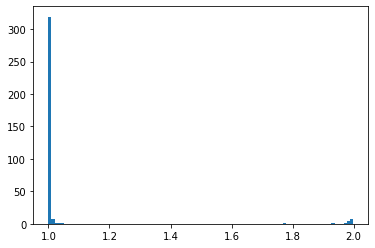

In [253]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.array(weights[0,:lenh,startd:].flatten()+1), bins=100);

In [0]:
import numpy as np
from IPython.core.display import display, HTML

def heat(sample,weights,dark=0.3):
    weights = (weights - weights.min())/(weights.max() - weights.min() + 1e-4)
    html = ''
    fmt = ' <span style="background-color: #{0:x}{0:x}ff">{1}</span>'
    for t,w in zip(sample,weights):
        c = int(256*((1.-dark)*(1.-w)+dark))
        html += fmt.format(c,idx2word[t])
    display(HTML(html))

In [255]:
heat(sample, weights[0,-1])

In [0]:
import pandas as pd
import seaborn as sns

In [0]:
columns = [idx2word[data[0,i]] for i in range(startd,maxlend)]
rows = [idx2word[data[0,i]] for i in range(maxlend+1,maxlend+lenh+1)]

In [0]:
df = pd.DataFrame(weights[0,:lenh,startd:],columns=columns,index=rows)

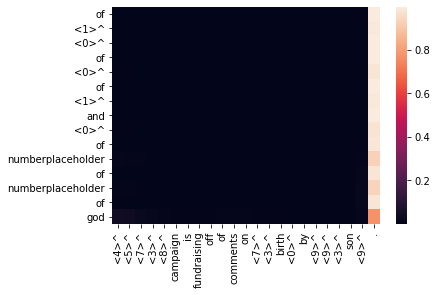

In [259]:
sns.heatmap(df);